In [28]:
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import os
import ipywidgets as widgets
from IPython.display import display
from rembg import remove
from sklearn.cluster import KMeans

# Fragrance Recommendation System

## Overview
This script extracts dominant colors from an image and recommends perfumes based on:
- **Color detection** → Matches colors with olfactive accords.
- **Situation-based filtering** → Suggests fragrances based on context (e.g., "formal event").
- **Preference filtering** → Recommends perfumes containing a specific accord.
- **Exclusion filtering** → Avoids perfumes with unwanted accords.
- **Gender filtering** → Returns perfumes based on gender (`Male`, `Female`, `Unisex`).


## Step 1: Load the Fragrance Database
This loads the dataset containing perfume information, including olfactive profiles and gender classification.

In [29]:
#Reading the database created for the fragrance recomendation system
fragrance_df = pd.read_csv("../data/fragrance_ML_model.csv")

## Step 2: Define fuction to remove the background from the image

In [30]:
def remove_background(image_path):
    """
    Removes background using rembg (fast and offline).
    """
    image = Image.open(image_path)
    output = remove(image)
    processed_image_path = "processed_image.png"
    output.save(processed_image_path)
    return processed_image_path

## Step 3: Extract Dominant Colors from uploaded image

In [31]:
def extract_dominant_colors(image_path, num_colors=3):
    """
    Extracts the most dominant colors using K-means clustering.
    """
    image = Image.open(image_path).convert("RGB")
    image = image.resize((100, 100))
    image_np = np.array(image)
    pixels = image_np.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    
    return [tuple(color) for color in dominant_colors]

## Step 3: Map Colors to Olfactive Accords

In [32]:
#Define color to accord mapping
COLOR_TO_ACCORD = {
    (255, 255, 0): ["citrus", "fruity", "sweet"],  # Yellow
    (0, 0, 255): ["marine", "aquatic", "ozonic"],  # Blue
    (245, 245, 220): ["powdery", "soft spicy", "musky"],  # Beige
    (255, 255, 255): ["clean", "aldehyde", "soft spicy"],  # White
    (128, 128, 128): ["musky", "powdery", "earthy"],  # Gray
    (255, 0, 255): ["sweet", "fruity", "floral"],  # Magenta
    (139, 69, 19): ["woody", "amber", "leather"],  # Brown
    (210, 180, 140): ["warm spicy", "woody", "sweet"],  # Light Brown
    (192, 192, 192): ["aldehyde", "fresh", "clean"],  # Metallic
    (255, 165, 0): ["citrus", "spicy", "warm"],  # Orange
    (0, 0, 0): ["leather", "smoky", "dark"],  # Black
    (255, 0, 0): ["spicy", "warm", "oriental"],  # Red
    (255, 192, 203): ["floral", "powdery", "sweet"],  # Pink
    (0, 255, 0): ["fresh", "herbal", "green"]  # Green
}



# Function to map colors to fragrance accords
def map_colors_to_accords(dominant_colors):
    accords = []
    for color in dominant_colors:
        closest_color = min(COLOR_TO_ACCORD.keys(), key=lambda c: np.linalg.norm(np.array(c) - np.array(color)))
        accords.extend(COLOR_TO_ACCORD[closest_color])
    return list(set(accords))

## Step 3: Define the Recommendation Function
This function processes the image, extracts dominant colors, matches them with accords, and filters perfumes based on the given criteria.
How filtering works:
1. **`preference`** → Filters perfumes that **contain** a specific scent profile in the `Olfactive Profile` column.
2. **`exclude`** → Removes perfumes that **contain** a specific scent profile in the `Olfactive Profile` column.
3. **`gender`** → Filters perfumes based on the `Gender` column (`Male`, `Female`, `Unisex`).

In [33]:
# Situation-based accords
SITUATION_TO_ACCORD = {
    "formal": ["woody", "spicy", "leather"],
    "casual": ["fresh", "citrus", "aquatic"],
    "romantic": ["floral", "sweet", "musky"],
    "sport": ["green", "aquatic", "ozonic"],
    "office": ["clean", "powdery", "aldehyde"]
}

In [34]:
# Fragrance recommendation function
def recommend_fragrance(image_path, situation=None, preference=None, exclude=None, gender=None, num_recommendations=5):
    """
    Recommends perfumes based on extracted colors, situation, and user preferences.
    """
    processed_image_path = remove_background(image_path)
    dominant_colors = extract_dominant_colors(processed_image_path)
    accords_segmented = map_colors_to_accords(dominant_colors)
    
    combined_accords = accords_segmented[:]
    if situation in SITUATION_TO_ACCORD:
        combined_accords.extend(SITUATION_TO_ACCORD[situation])
    combined_accords = list(set(combined_accords))
    
    filtered_df = fragrance_df[fragrance_df["Olfactive Profile"].str.contains('|'.join(combined_accords), case=False, na=False)]
    
    if gender:
        filtered_df = filtered_df[filtered_df["Gender"].str.contains(gender, case=False, na=False)]
    if preference:
        filtered_df = filtered_df[filtered_df["Olfactive Profile"].str.contains(preference, case=False, na=False)]
    if exclude:
        filtered_df = filtered_df[~filtered_df["Olfactive Profile"].str.contains(exclude, case=False, na=False)]
    
    if filtered_df.empty:
        return "No perfumes found after applying filters. Try adjusting your criteria."
    
    top_perfumes = filtered_df.sort_values(by=["Rating Value", "Rating Count"], ascending=[False, False])
    return top_perfumes.head(num_recommendations)

In [35]:
# Jupyter file uploader widget
uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
display(uploader)

FileUpload(value={}, accept='.png,.jpg,.jpeg', description='Upload')

## Step 4: Run a Test Example
This runs the function with a sample image, applying filters for situation, preference, exclusion, and gender.

In [36]:
#Load the image 
uploader = widgets.FileUpload(accept='.png,.jpg,.jpeg', multiple=False)
display(uploader)

FileUpload(value={}, accept='.png,.jpg,.jpeg', description='Upload')

In [42]:
#Save the image
if uploader.value:
    uploaded_file = list(uploader.value.values())[0]
    image_path = "test_image.jpg"
    with open(image_path, "wb") as f:
        f.write(uploaded_file['content'])
    print(f"Image saved as {image_path}")
else:
    print("No file uploaded! Please upload an image first.")

Image saved as test_image.jpg


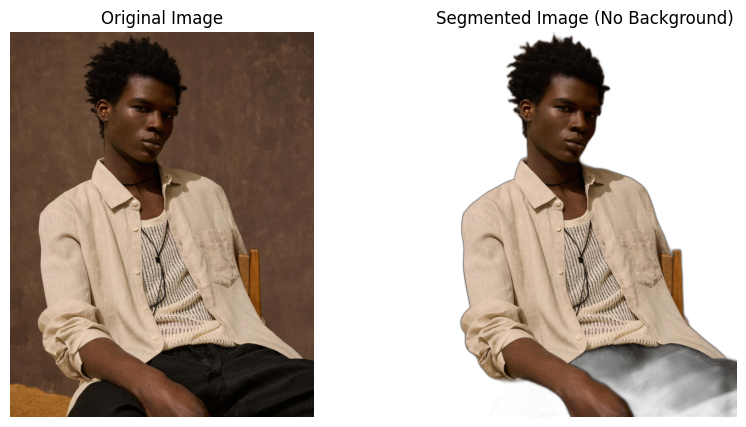

In [43]:
#Verify removal of background works perfectly
segmented_image_path = remove_background("test_image.jpg")


original = Image.open("test_image.jpg")
segmented = Image.open(segmented_image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmented)
plt.title("Segmented Image (No Background)")
plt.axis("off")

plt.show()

In [44]:
#Try to extract the dominant colors from the image
dominant_colors = extract_dominant_colors(segmented_image_path, num_colors=3)
print("Dominant Colors Extracted:", dominant_colors)

Dominant Colors Extracted: [(4, 2, 1), (198, 174, 150), (106, 71, 48)]


In [45]:
#Try conversion to accords
color_accords = map_colors_to_accords(dominant_colors)
print("Mapped Olfactive Accords:", color_accords)

Mapped Olfactive Accords: ['woody', 'warm spicy', 'dark', 'amber', 'leather', 'smoky', 'sweet']


In [46]:
#Try recommendation system itself
recommendations = recommend_fragrance(
    image_path="test_image.jpg",  # Imagen de prueba
    situation="casual",           # Situación del usuario
    preference="lemon",           # Preferencias olfativas
    exclude="sweet",              # Notas a excluir
    gender="unisex",                 # Género de la fragancia
    num_recommendations=5         # Número de sugerencias
)

print(recommendations)

                               Perfume                  Brand   Country  \
20916                  mystery for him                   mith  thailand   
20912                   folha imperial                granado    brazil   
20908      amber aoud absolue precieux              roja dove        uk   
20840  purple velvet fioletovyj barhat              odoratika    russia   
20815                      dapper 1959  alexandria fragrances       usa   

       Gender  Rating Value  Rating Count  Year  \
20916  unisex          4.68            69  2023   
20912  unisex          4.68            28  2021   
20908  unisex          4.67           184  2012   
20840  unisex          4.59            34  2017   
20815  unisex          4.58            40  2019   

                                                     Top  \
20916                                 lemon, pink pepper   
20912          sicilian lemon, bergamot, mandarin orange   
20908                              lime, lemon, bergamot   
20